# Extreme Heat: It's All Relative! 
## A Lesson on the Heat Index and Why the Mountains Aren't Always an Escape from It.
## Written By Jared Rennie (@jjrennie)

I do not like the heat, yet whenever I complain about it in the mountains of North Carolina, I always get the following comment:

<span style="color: red">***"aT lEaSt yOu dOn'T lIvE iN rAlEiGh or cHaRlOtTe wHeRe iT's mUcH hOtTeR"***</span>

Sure, it's much hotter at lower elevations, but I don't live in Raleigh or Charlotte, *I LIVE IN THE WESTERN NORTH CAROLINA MOUNTAINS* so extreme heat in our area can still have an impact, even if it's in the low to mid 90s. It may not affect all of us, but it certainly <a href='https://www.weather.gov/images/wrn/Infographics/_heat-vulnerable-populations-descriptions.png' target='blank'>affects those vulnerable to heat</a>.

Another gripe I have is that <a href='https://journals.ametsoc.org/view/journals/wcas/9/1/wcas-d-15-0037_1.xml' target="_blank">according to the National Weather Service</a>, a heat advisory is issued ANYWHERE IN THE STATE OF NORTH CAROLINA if the heat Index is 105°F.

***Um...what?*** 

It has NEVER gotten to 105 here in the mountains. No wonder why we have <a href='https://mesonet.agron.iastate.edu/plotting/auto/plot/90/t:state::v:total::ilabel:no::geo:ugc::drawc:yes::year:1986::year2:2025::sdate:1986-01-01%200000::edate:2025-08-20%200000::network:WFO::station:DMX::state:NC::fema:7::phenomena:HT::significance:Y::cmap:YlOrRd::_r:t::dpi:100.png' target='_blank'>NEVER BEEN ISSUED A HEAT ADVISORY IN OUR AREA!!!</a>

Just because we do not get triple digit heat a lot does not mean we are exempted from heat exteremes and associated impacts!

**And I'm going to prove it to you using data and statistics!**

This notebook will tap into data archived by <a href='https://www.ncei.noaa.gov/' target="_blank">NOAA's National Centers for Environmetal Information</a>, calculate the Heat Index used by the National Weather Service, and use statistical percentiles to show what thresholds would be considered out of the ordinary, thus showing heat can still be a problem in the mountains.

**YES, I AM THAT PETTY!**

The dataset we will be using is from the Global Historical Climatology Network's (GHCN's) hourly dataset, which includes multiple sources of US and international data, including airport data from the ASOS network. If you would like to learn more about this dataset, check out the information below. 

- GHCNh Info: https://www.ncei.noaa.gov/products/global-historical-climatology-network-hourly
- GHCNh Documentation: https://www.ncei.noaa.gov/oa/global-historical-climatology-network/hourly/doc/ghcnh_DOCUMENTATION.pdf

This notebook is designed so you do not have to download any data locally, and with just a few lines of code, you can develop data and plots at your fingertips. Let's get into it!

### What You Need

First off, the entire codebase works in Python 3. In addition to base Python, you will need the following packages installed: 
- pandas and numpy (to slice annd dice the data)
- matplotlib (to make pretty plots)

The "easiest" way is to install these is by installing <a href='https://www.anaconda.com' target="_blank">anaconda</a>, and then applying <a href='https://conda-forge.org/' target="_blank">conda-forge</a>. Afterward, then you can install the above packages. 

### Importing Packages
Assuming you did the above, it should (in theory) import everything no problem:

In [1]:
# Import Packages
import sys, math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
import matplotlib.dates as mdates
import numpy as np

print("SUCCESS!")

SUCCESS!


If you made it this far, great!

### Insert Arguments
In order for the codebase to work, we need to set up some manual inputs

**1) STATION IDS**

We first need to look at 2 stations for comparison. You can find the entire list of stations <a href='https://www.ncei.noaa.gov/oa/global-historical-climatology-network/hourly/doc/ghcnh-station-list.csv' target='blank'>here</a>.

The code is designed to get either the airport ID (4 characters) or the ghcn ID (11 characters) The two stations we will be getting are:
- Asheville Regional Airport (KAVL | USW00003812): **~2,100 feet above sea level**
- Raleigh-Durham Int'l Airport (KRDU | USW00013722) **~400 feet above sea level**

**2) PERIOD OF RECORD**

GHCNh data goes back to the 1700s! Since a stations entire period of record is very large, the database not only splits up data by year, but also uses the parquet file format. No need to worry though, we can read this data easily using a python package pandas, no downloading of the data required! 

For the sake of analysis, let's look at data between 1980 and 2024.

**3) AUTHOR**

And finally, we want to give YOU credit for the plots we make, so add your name as the author

 **Change the arguments below to your liking**

In [2]:
# Insert Arguments Here
stationIDS = ['KAVL','KRDU']
start_year=1980
end_year=2024
author='Not Jared Rennie'

### Get Metadata For Each Station
First, let's get some metadata for the two stations. This will be helpful when plotting later

In [3]:
stationID1=stationIDS[0] # KAVL
stationID2=stationIDS[1] # KRDU

ghcnh_meta_url='https://www.ncei.noaa.gov/oa/global-historical-climatology-network/hourly/doc/ghcnh-station-list.csv'

# Pull Data into Pandas DataFrame
try:
  ghcnhMeta = pd.read_csv(ghcnh_meta_url)
  print('SUCCESS')
except Exception as e:
  print('SOMETHING WENT WRONG: ',e)

stationMeta = ghcnhMeta[ghcnhMeta['ICAO'].isin(stationIDS)].reset_index()
stationMeta

SUCCESS


,index,GHCN_ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN,(US)HCN_(US)CRN,WMO_ID,ICAO
0,31253,USW00003812,35.4317,-82.5378,645.6,NC,ASHEVILLE AP,NaN,NaN,72315,KAVL
1,31713,USW00013722,35.8922,-78.7819,120.4,NC,RALEIGH AP,NaN,NaN,72306,KRDU


### Get Data For Each Station
We will now import the data for each station, and place it into its own pandas dataframe. The database has ***hundreds of columns***, so we only need to pull in a few data variables to calculate humidity and heat metrics

In [4]:
inData = {}
inColumns=['DATE','temperature','relative_humidity','dew_point_temperature']

**NOTE:** This may take a few monments

In [5]:
%%time

print("Getting Data from "+str(start_year)+" to "+str(end_year))
print("Takes a few moments")

for stationID in stationIDS:
    ghcnID=stationMeta[stationMeta['ICAO']==stationID]['GHCN_ID'].values[0]
    
    print('\t',stationID,ghcnID)
    for inYear in range(start_year,end_year+1):        
        # DEFINE URL (parquet)
        ghcnh_url = 'https://www.ncei.noaa.gov/oa/global-historical-climatology-network/hourly/access/by-year/'+str(inYear)+'/parquet/GHCNh_'+str(ghcnID)+'_'+str(inYear)+'.parquet'
        
        # Pull Data into Pandas DataFrame
        try:
          ghcnhYear = pd.read_parquet(ghcnh_url,columns=inColumns)
        except Exception as e:
          print('SOMETHING WENT WRONG: ',e)
          continue
    
        # Build DataFrame
        if inYear == start_year:
            ghcnhPandas=ghcnhYear
        else:
            ghcnhPandas = pd.concat([ghcnhPandas, ghcnhYear], ignore_index=True)

    inData[stationID]=ghcnhPandas
print('SUCCESS')

Getting Data from 1980 to 2024
Takes a few moments
	 KAVL USW00003812
	 KRDU USW00013722
SUCCESS
CPU times: user 2.69 s, sys: 358 ms, total: 3.05 s
Wall time: 17.9 s


If it says "SUCCESS!" then congrats you got the data!

### Let's check the data!
How does it look? 

In [6]:
print(stationID1)
inData[stationID1] # AVL

KAVL


,DATE,temperature,relative_humidity,dew_point_temperature
0,1980-01-01T00:00:00,5.0,100.0,5.0
1,1980-01-01T01:00:00,5.0,100.0,5.0
2,1980-01-01T02:00:00,5.0,100.0,5.0
3,1980-01-01T03:00:00,5.0,100.0,5.0
4,1980-01-01T04:00:00,5.0,96.0,4.4
...,...,...,...,...
551279,2024-12-31T20:54:00,16.1,50.0,5.6
551280,2024-12-31T21:00:00,16.1,50.0,5.6
551281,2024-12-31T21:54:00,15.6,32.0,-1.1
551282,2024-12-31T22:54:00,13.9,36.0,-1.1


In [7]:
print(stationID2)
inData[stationID2] # RDU

KRDU


,DATE,temperature,relative_humidity,dew_point_temperature
0,1980-01-01T00:00:00,7.8,61.0,0.6
1,1980-01-01T01:00:00,5.6,71.0,0.6
2,1980-01-01T02:00:00,4.4,73.0,0.0
3,1980-01-01T03:00:00,3.3,79.0,0.0
4,1980-01-01T04:00:00,4.4,73.0,0.0
...,...,...,...,...
486459,2024-12-31T21:51:00,17.8,65.0,11.1
486460,2024-12-31T22:51:00,16.7,73.0,11.7
486461,2024-12-31T23:23:00,16.7,73.0,11.7
486462,2024-12-31T23:44:00,15.6,75.0,11.1


### Let's cleanup the data!
Before we move forward, we need to do a few things
- Remove any missing data (classifies as 'NA')
- Convert data from Celsius to Fahrenheit
- Convert date to a python 'datetime' format, which will help us with some time calculations

In [8]:
for stationID in stationIDS:
    # Drop NA and make a copy
    df = inData[stationID].dropna().copy()
    
    # Convert C to F
    df['temperature_F'] = (df['temperature'] * 1.8) + 32.
    df = df.drop('temperature', axis=1)
    
    df['dewPoint_F'] = (df['dew_point_temperature'] * 1.8) + 32.
    df = df.drop('dew_point_temperature', axis=1)
    
    # Ensure DATE is datetime
    df['DATE'] = pd.to_datetime(df['DATE'])

    # Assign back to inData
    inData[stationID] = df

### Calculate Heat Index
Now that we have Relative Humidity and Temperature in appropriate formats, let's get the Heat Index. We are using the equation provided by the <a href='https://www.wpc.ncep.noaa.gov/html/heatindex_equation.shtml' target="_blank">National Weather Service Weather Prediction Center</a>. Below is the function to calculate Heat Index.

In [9]:
def calc_heat_index(row):
    """Calculate Heat Index based on NWS equation.
        http://www.wpc.ncep.noaa.gov/html/heatindex_equation.shtml
        https://www.wpc.ncep.noaa.gov/html/heatindex.shtml
    
    Derived from Alex Markov and meteocalc: https://pypi.org/project/meteocalc/
    """

    c1 = -42.379
    c2 = 2.04901523
    c3 = 10.14333127
    c4 = -0.22475541
    c5 = -6.83783e-3
    c6 = -5.481717e-2
    c7 = 1.22874e-3
    c8 = 8.5282e-4
    c9 = -1.99e-6

    Tf=row['temperature_F']
    RH=row['relative_humidity']
    
    # Calculate Simple Forumla First (HI < 80)
    HI = 0.5 * (Tf + 61. + (Tf - 68.) * 1.2 + RH * 0.094)

    if HI >= 80.:
        # use Rothfusz regression
        HI = math.fsum([
            c1,
            c2 * Tf,
            c3 * RH,
            c4 * Tf * RH,
            c5 * Tf**2.,
            c6 * RH**2.,
            c7 * Tf**2. * RH,
            c8 * Tf * RH**2.,
            c9 * Tf**2. * RH**2.,
        ])
    
    # ADJUSTMENT 1: If RH is less than 13% and the temperature is between 80 and 112 degrees F 
    #               then the following adjustment is SUBTRACTED FROM HI:
    if RH < 13. and Tf >=80. and Tf <= 112.:
        adjustment=((13.-RH)/4.)*math.sqrt((17.-abs(Tf-95.))/17.)
        HI=HI-adjustment

    # ADJUSTMENT 2: If the RH is greater than 85% and the temperature is between 80 and 87 degrees F
    #               then the following adjustment is ADDED TO HI:
    if RH > 85. and Tf >=80. and Tf <= 87.:
        adjustment=((RH-85.)/10.) * ((87.-Tf)/5.)
        HI=HI+adjustment
        
    return HI

We will now create a New Column Called 'HI' that will calculate the heat index.

In [10]:
%%time

# Create Heat Index 
inData[stationID1]['HI'] = inData[stationID1].apply(calc_heat_index, axis=1) # AVL
inData[stationID2]['HI'] = inData[stationID2].apply(calc_heat_index, axis=1) # RDU

CPU times: user 7.37 s, sys: 157 ms, total: 7.52 s
Wall time: 7.52 s


For the purposes of this training, let's only take data for the warmest months of the year (June to August)

In [11]:
# Filter for months from June (6) to August (8)
subsetData={}
subsetData[stationID1] = inData[stationID1][inData[stationID1]['DATE'].dt.month.between(6, 8)].reset_index(drop=True) # AVL
subsetData[stationID2] = inData[stationID2][inData[stationID2]['DATE'].dt.month.between(6, 8)].reset_index(drop=True) # RDUs

Let's check the data now

In [12]:
print(stationID1) # AVL
subsetData[stationID1]

KAVL


,DATE,relative_humidity,temperature_F,dewPoint_F,HI
0,1980-06-01 00:00:00,84.0,73.04,68.00,73.992
1,1980-06-01 01:00:00,87.0,69.98,66.02,70.767
2,1980-06-01 02:00:00,96.0,68.00,66.92,69.012
3,1980-06-01 03:00:00,93.0,68.00,66.02,68.871
4,1980-06-01 04:00:00,93.0,66.02,64.04,66.693
...,...,...,...,...,...
139375,2024-08-31 21:00:00,90.0,69.98,66.92,70.908
139376,2024-08-31 21:27:00,87.0,71.96,68.00,72.945
139377,2024-08-31 21:54:00,82.0,73.94,68.00,74.888
139378,2024-08-31 22:54:00,79.0,73.94,66.92,74.747


In [13]:
print(stationID2) # RDU
subsetData[stationID2]

KRDU


,DATE,relative_humidity,temperature_F,dewPoint_F,HI
0,1980-06-01 00:00:00,72.0,78.98,69.08,79.962000
1,1980-06-01 01:00:00,71.0,77.00,66.92,77.737000
2,1980-06-01 02:00:00,79.0,73.94,66.92,74.747000
3,1980-06-01 03:00:00,90.0,71.06,68.00,72.096000
4,1980-06-01 04:00:00,90.0,71.06,68.00,72.096000
...,...,...,...,...,...
118628,2024-08-31 20:51:00,58.0,89.96,73.04,98.477599
118629,2024-08-31 21:00:00,58.0,89.96,73.04,98.477599
118630,2024-08-31 21:51:00,59.0,87.08,71.06,92.818450
118631,2024-08-31 22:51:00,61.0,87.08,71.96,93.642129


### Let's see what the max heat index is for each station.

In [14]:
# Get Max Heat Index for each station
for stationID in stationIDS:
    HIMax = "%.1f" % (subsetData[stationID]['HI'].max())
    print(stationID,'Max Heat Index: ',HIMax,'°F')

KAVL Max Heat Index:  109.8 °F
KRDU Max Heat Index:  116.8 °F


OH LOOK! The KRDU station is already higher than KAVL! ***We're off to a great start proving my point!*** But that's not really stats now is it? Let's look at the percentiles:

### Show me the percentiles!
The following block will generate 50th (median), 90th, 95th, and 99th percentiles. For a better understanding what these are, check out <a href='https://www.dummies.com/article/academics-the-arts/math/statistics/how-to-find-a-percentile-for-a-normal-distribution-169600/' target='blank'>this tutorial</a>.

In [15]:
# Create Percentiles, and hold onto the 99th percentile
perc_99={}
for stationID in stationIDS: 
    print(stationID)
    
    # Calculate the 50th percentile (median)
    percentile_50 = "%.1f" % (subsetData[stationID]['HI'].quantile(0.50))
    print('\t50th Percentile: ',percentile_50,'°F')
    
    # Calculate the 90th percentile 
    percentile_90 = "%.1f" % (subsetData[stationID]['HI'].quantile(0.90))
    print('\t90th Percentile: ',percentile_90,'°F')
    
    # Calculate the 95th percentile
    percentile_95 = "%.1f" % (subsetData[stationID]['HI'].quantile(0.95))
    print('\t95th Percentile: ',percentile_95,'°F')
    
    # Calculate the 99th percentile
    percentile_99 = "%.1f" % (subsetData[stationID]['HI'].quantile(0.99))
    print('\t99th Percentile: ',percentile_99,'°F')
    perc_99[stationID]=percentile_99

KAVL
	50th Percentile:  70.6 °F
	90th Percentile:  83.5 °F
	95th Percentile:  86.5 °F
	99th Percentile:  91.3 °F
KRDU
	50th Percentile:  77.2 °F
	90th Percentile:  93.6 °F
	95th Percentile:  97.4 °F
	99th Percentile:  103.2 °F


***INTERESTING!!!!*** The 99th percentile of Asheville never hits 100!, but a value in the low 90's is considered pretty extreme! And if we are going with the NWS criteria of 105°F for heat advisory issuance, the RDU 99th percentile is within the possible realm of hitting 105. AVL is not.

### Output to CSV
This step outputs each station's data to a CSV file so you can load it and play with it elsewhere. Or you can keep playing with it here. You do you!

In [16]:
%%time 

# Send to CSV
for stationID in stationIDS: 
    outFile='./'+stationID+'_HourlyHI.csv'
    inData[stationID].to_csv(outFile,index=False)
    
    # If you made it this far. Success!
    print('SUCESSFULLY PLACED DATA IN:',outFile)

SUCESSFULLY PLACED DATA IN: ./KAVL_HourlyHI.csv
SUCESSFULLY PLACED DATA IN: ./KRDU_HourlyHI.csv
CPU times: user 4.93 s, sys: 38.6 ms, total: 4.96 s
Wall time: 4.97 s


### Plot a Day's Worth of Hourly Data

Now let's plot data for each station during one of North Carolina's Hottest Days <a href='https://climate.ncsu.edu/blog/2015/08/nc-extremes-our-history-of-record-heat/' target='_blank'>(August 1983)</a>

PLOTTING
KAVL


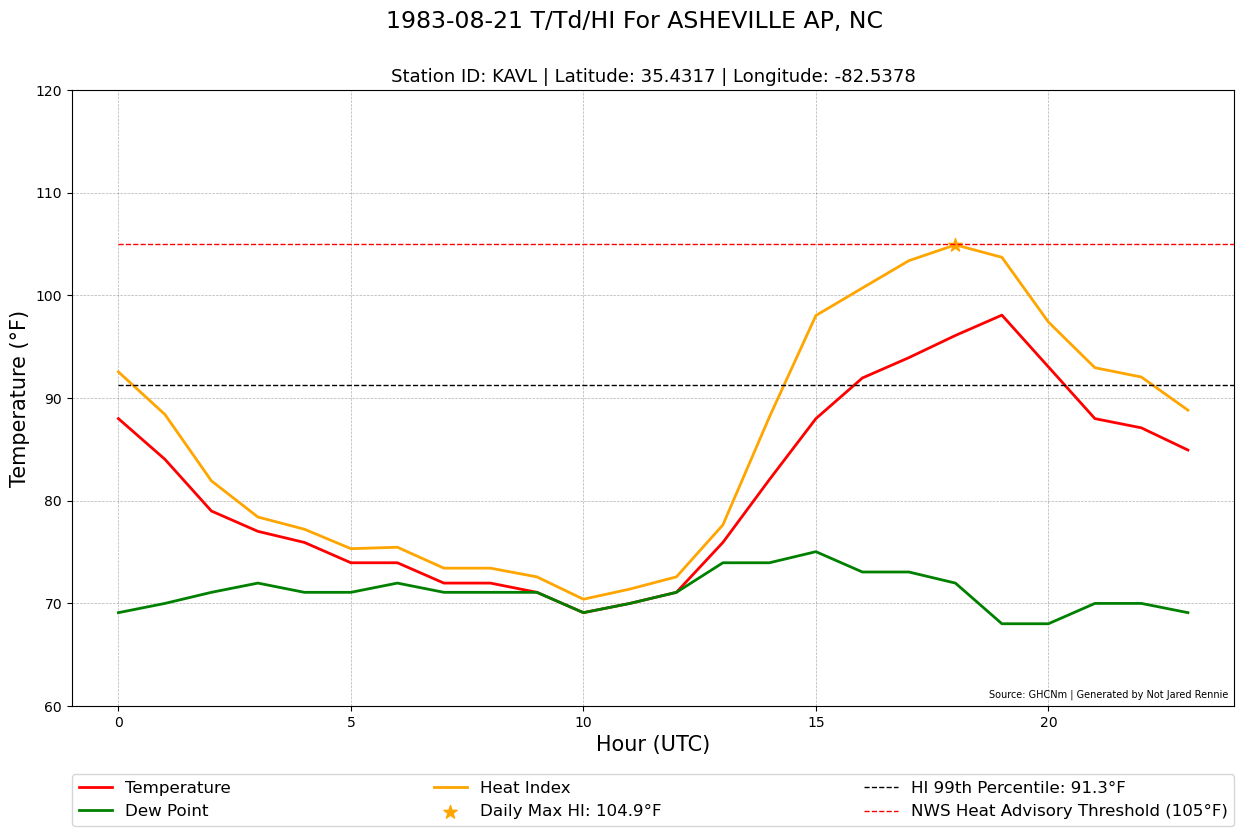

KRDU


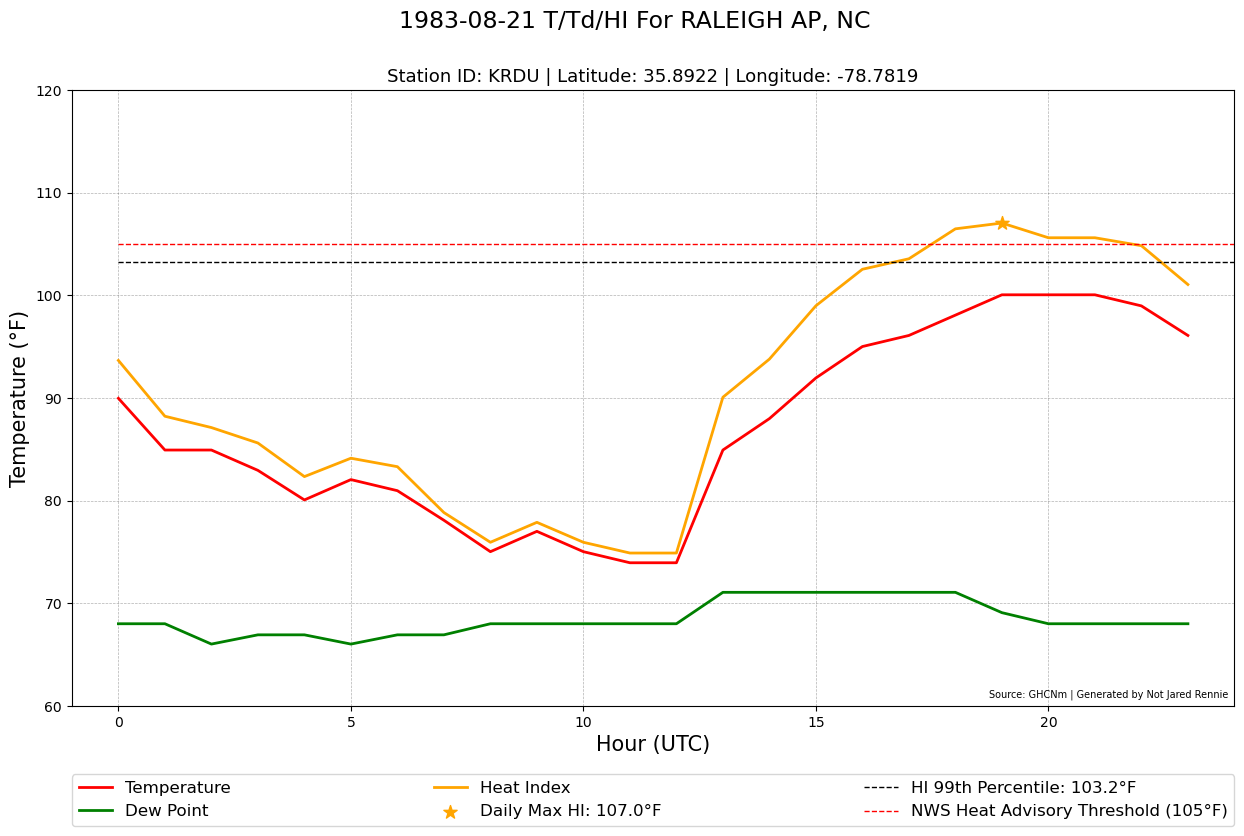

CPU times: user 1.47 s, sys: 220 ms, total: 1.69 s
Wall time: 1.3 s


In [17]:
%%time 
inDate='1983-08-21'

#################################################
# PLOT
print("PLOTTING")

dpi=100
for index, row in stationMeta.iterrows():
    stationID=row['ICAO']
    stnName=row['NAME']
    stnState=row['STATE']
    stnLat=row['LATITUDE']
    stnLon=row['LONGITUDE']
    
    print(stationID)
    plotData = inData[stationID][inData[stationID]['DATE'].dt.date == pd.to_datetime(inDate).date()].reset_index()
    
    # Set up the plot
    fig, axf = plt.subplots(figsize=(15, 8), edgecolor='white', facecolor='white', dpi=dpi)
    
    # Add grid lines
    plt.grid(color='black', linestyle='--', linewidth=0.5, alpha=0.3)
    
    # Plot Raw Data
    plt.plot(np.arange(0,len(plotData['temperature_F'])), plotData['temperature_F'], linewidth=2, color='red', label="Temperature",zorder=99)
    plt.plot(np.arange(0,len(plotData['dewPoint_F'])), plotData['dewPoint_F'], linewidth=2, color='green', label="Dew Point",zorder=99)
    plt.plot(np.arange(0,len(plotData['HI'])), plotData['HI'], linewidth=2, color='orange', label="Heat Index",zorder=99)

    # Plot Max HI
    maxX=plotData['HI'].idxmax()
    maxY="%.1f" % (plotData.loc[plotData['HI'].idxmax()]['HI'])
    plt.scatter(maxX,float(maxY),s=100,c='orange',marker='*',zorder=100,label='Daily Max HI: '+str(maxY)+'°F')
    
    # Plot 99th Percentile
    plt.hlines(float(perc_99[stationID]),0,len(plotData['HI']),colors='black',linewidth=1, linestyles='dashed',label="HI 99th Percentile: "+str(perc_99[stationID])+"°F",zorder=100)

    # Plot NWS Heat Advisory Threshold
    plt.hlines(float(105.),0,len(plotData['HI']),colors='red',linewidth=1, linestyles='dashed',label="NWS Heat Advisory Threshold (105°F)",zorder=100)
    
    # Plot Legend
    plt.legend(bbox_to_anchor=(0., -.195, 1., -1.02), loc=3, ncol=3, mode="expand", borderaxespad=0., fontsize=12)

    # Set X/Y limits
    ymin=60.
    ymax=120.
    plt.ylim(ymin, ymax)
    plt.xlim(-1, len(plotData['temperature_F'])) 
    
    # Plot X-Axis Labels/Ticks
    plt.xlabel('Hour (UTC)', fontsize=15, color='black')
    
    # Plot Y-Axis Labels/Ticks (Left Side, degF)
    plt.ylabel(r'Temperature (°F)', fontsize=15, color='black')
    
    # Plot Title/Subtitle/Annotations
    plt.suptitle(str(inDate)+' T/Td/HI For '+stnName+', '+stnState, fontsize=17,color='black')
    plt.title('Station ID: '+stationID+' | Latitude: '+str(stnLat)+' | Longitude: '+str(stnLon), fontsize=13,color='black')
    plt.annotate('Source: GHCNm | Generated by '+author,xy=(0.995, 0.01), xycoords='axes fraction', fontsize=7,horizontalalignment='right', verticalalignment='bottom')
    
    # Save Figure
    outfile = './'+stationID+'_hi_'+str(inDate)+'.png'
    plt.savefig(outfile, dpi=dpi,bbox_inches='tight')
    plt.show()

While this was one of the hottest days in the North Carolina Record (low to mid 100s), The difference between the highest estimated Heat Index at RDU and its 99th percentile is only a 4 degree difference. Yet in Asheivlle it's a ***THIRTEEN*** degree difference! 

And remember, a Heat Advisory is issued ANYWHERE IN NORTH CAROLINA if it hits 105°F. While the heat index is an estimation, the <span style="color: red">***HOTTEST DAY EVER IN ASHEVILLE DOESN'T EVEN HIT THAT THRESHOLD***<span>.

Some of you are now probably wondering 'wait a minute, this is hourly data, so we are using ALL hours of the day. Is this accurate? Good catch, so let's turn this into daily max and min data to FURTHER prove my point.

### Get Daily Max/Min
This block of code will convert the hourly data to daily data, then get the max and min for each day for the period of record. We also again cut it off to some of the warmest months of the year (June to August)

In [18]:
%%time 

inDataDaily={}

# Get Max/Min Daily Heat Index for each station
for stationID in stationIDS:

    # Create a new column for just the date part
    inData[stationID]['day'] = inData[stationID]['DATE'].dt.date

    # Group by the day and aggregate the max and min of HI
    daily_HI = inData[stationID].groupby('day')['HI'].agg(['max', 'min']).reset_index()

    # Rename columns for clarity
    daily_HI.columns = ['DATE', 'HI_max', 'HI_min']
    daily_HI['DATE'] = pd.to_datetime(daily_HI['DATE'])
    inDataDaily[stationID]=daily_HI

# Filter for months from June (6) to August (8)
subsetData={}
subsetData[stationID1] = inDataDaily[stationID1][inDataDaily[stationID1]['DATE'].dt.month.between(6, 8)].reset_index(drop=True) # AVL
subsetData[stationID2] = inDataDaily[stationID2][inDataDaily[stationID2]['DATE'].dt.month.between(6, 8)].reset_index(drop=True) # RDUs

CPU times: user 273 ms, sys: 28.9 ms, total: 302 ms
Wall time: 301 ms


Let's see the result

In [19]:
print(stationID1)
subsetData[stationID1] #AVL

KAVL


,DATE,HI_max,HI_min
0,1980-06-01,83.604651,62.478
1,1980-06-02,88.212552,61.149
2,1980-06-03,92.426602,63.515
3,1980-06-04,83.805257,69.777
4,1980-06-05,84.380318,60.867
...,...,...,...
4135,2024-08-27,89.323754,61.008
4136,2024-08-28,91.187544,63.327
4137,2024-08-29,95.409466,67.683
4138,2024-08-30,93.201748,66.834


In [20]:
print(stationID2)
subsetData[stationID2] # RDU

KRDU


,DATE,HI_max,HI_min
0,1980-06-01,93.714455,70.059
1,1980-06-02,95.441322,72.096
2,1980-06-03,101.451772,73.992
3,1980-06-04,91.460470,74.133
4,1980-06-05,82.412829,57.783
...,...,...,...
4135,2024-08-27,102.895694,69.777
4136,2024-08-28,102.895694,72.804
4137,2024-08-29,107.782564,73.992
4138,2024-08-30,101.922870,74.274


Let's do the percentiles on the daily data and see what comes out

In [21]:
# Create Percentiles, and hold onto the 99th percentile
perc_99_max={}
for stationID in stationIDS: 
    print(stationID)
    
    # Calculate the 50th percentile (median)
    percentile_50 = "%.1f" % (subsetData[stationID]['HI_max'].quantile(0.50))
    print('\tDaily Max 50th Percentile: ',percentile_50,'°F')
    
    # Calculate the 90th percentile 
    percentile_90 = "%.1f" % (subsetData[stationID]['HI_max'].quantile(0.90))
    print('\tDaily Max 90th Percentile: ',percentile_90,'°F')
    
    # Calculate the 95th percentile
    percentile_95 = "%.1f" % (subsetData[stationID]['HI_max'].quantile(0.95))
    print('\tDaily Max 95th Percentile: ',percentile_95,'°F')
    
    # Calculate the 99th percentile
    percentile_99 = "%.1f" % (subsetData[stationID]['HI_max'].quantile(0.99))
    print('\tDaily Max 99th Percentile: ',percentile_99,'°F')
    perc_99_max[stationID]=percentile_99

KAVL
	Daily Max 50th Percentile:  84.1 °F
	Daily Max 90th Percentile:  91.3 °F
	Daily Max 95th Percentile:  92.9 °F
	Daily Max 99th Percentile:  96.4 °F
KRDU
	Daily Max 50th Percentile:  92.5 °F
	Daily Max 90th Percentile:  101.9 °F
	Daily Max 95th Percentile:  104.6 °F
	Daily Max 99th Percentile:  109.3 °F


It comes as ***NO SURPRISE*** these are warmer than the hourly counterparts. And again, the RDU values are well within the 105°F realm for a heat advisory issuance, BUT NOT AVL!. 

Another issue with extreme heat are overnight miniumn temperatures, because if folks don't have the ability to cool off, heat issues can continue for longer periods of time. So for funsies... let's do minimum temperature as well.

In [22]:
# Create Percentiles, and hold onto the 99th percentile
perc_99_min={}
for stationID in stationIDS: 
    print(stationID)
    
    # Calculate the 50th percentile (median)
    percentile_50 = "%.1f" % (subsetData[stationID]['HI_min'].quantile(0.50))
    print('\tDaily Min 50th Percentile: ',percentile_50,'°F')
    
    # Calculate the 90th percentile 
    percentile_90 = "%.1f" % (subsetData[stationID]['HI_min'].quantile(0.90))
    print('\tDaily Min 90th Percentile: ',percentile_90,'°F')
    
    # Calculate the 95th percentile
    percentile_95 = "%.1f" % (subsetData[stationID]['HI_min'].quantile(0.95))
    print('\tDaily Min 95th Percentile: ',percentile_95,'°F')
    
    # Calculate the 99th percentile
    percentile_99 = "%.1f" % (subsetData[stationID]['HI_min'].quantile(0.99))
    print('\tDaily Min 99th Percentile: ',percentile_99,'°F')
    perc_99_min[stationID]=percentile_99

KAVL
	Daily Min 50th Percentile:  64.7 °F
	Daily Min 90th Percentile:  69.0 °F
	Daily Min 95th Percentile:  70.2 °F
	Daily Min 99th Percentile:  72.2 °F
KRDU
	Daily Min 50th Percentile:  70.9 °F
	Daily Min 90th Percentile:  75.6 °F
	Daily Min 95th Percentile:  76.6 °F
	Daily Min 99th Percentile:  78.9 °F


Once again, ***MY POINT STILL STANDS!*** No matter how you slice and dice it, extreme temperatures at higher elevations are going to have lower thresholds than areas at sea level. 

<span style="color: red">So maybe we need to re-visit that 105°F threshold?</span>

### Output to CSV
Let's output this data to a CSV file so you can load it and play with it elsewhere. 

In [23]:
%%time
# Send to CSV
for stationID in stationIDS: 
    outFile='./'+stationID+'_DailyHI.csv'
    inDataDaily[stationID].to_csv(outFile,index=False)
    
    # If you made it this far. Success!
    print('SUCESSFULLY PLACED DATA IN:',outFile)

SUCESSFULLY PLACED DATA IN: ./KAVL_DailyHI.csv
SUCESSFULLY PLACED DATA IN: ./KRDU_DailyHI.csv
CPU times: user 110 ms, sys: 0 ns, total: 110 ms
Wall time: 110 ms


### Plot for a year's worth of daily data

Now let's Plot A Years Worth of Data and see how the extreme thresholds hold up for a given year. 

PLOTTING
KAVL


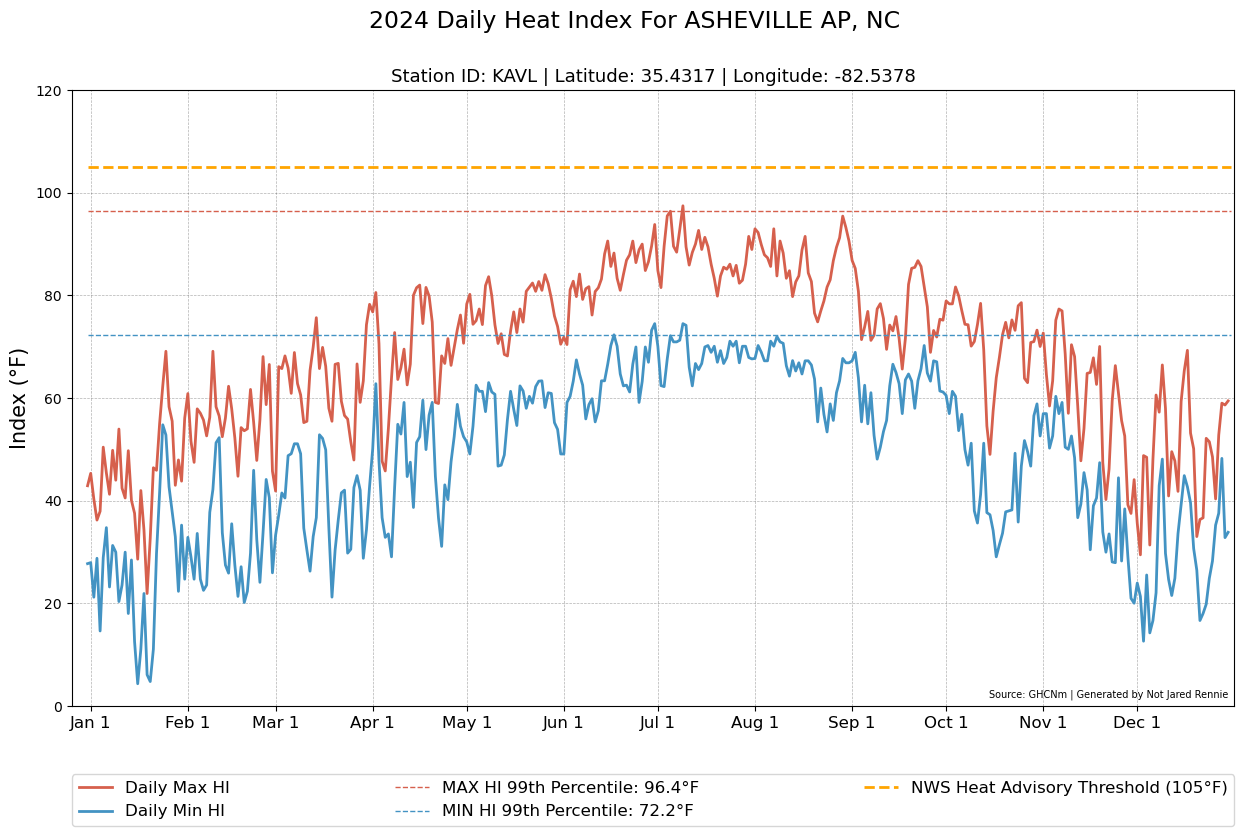

KRDU


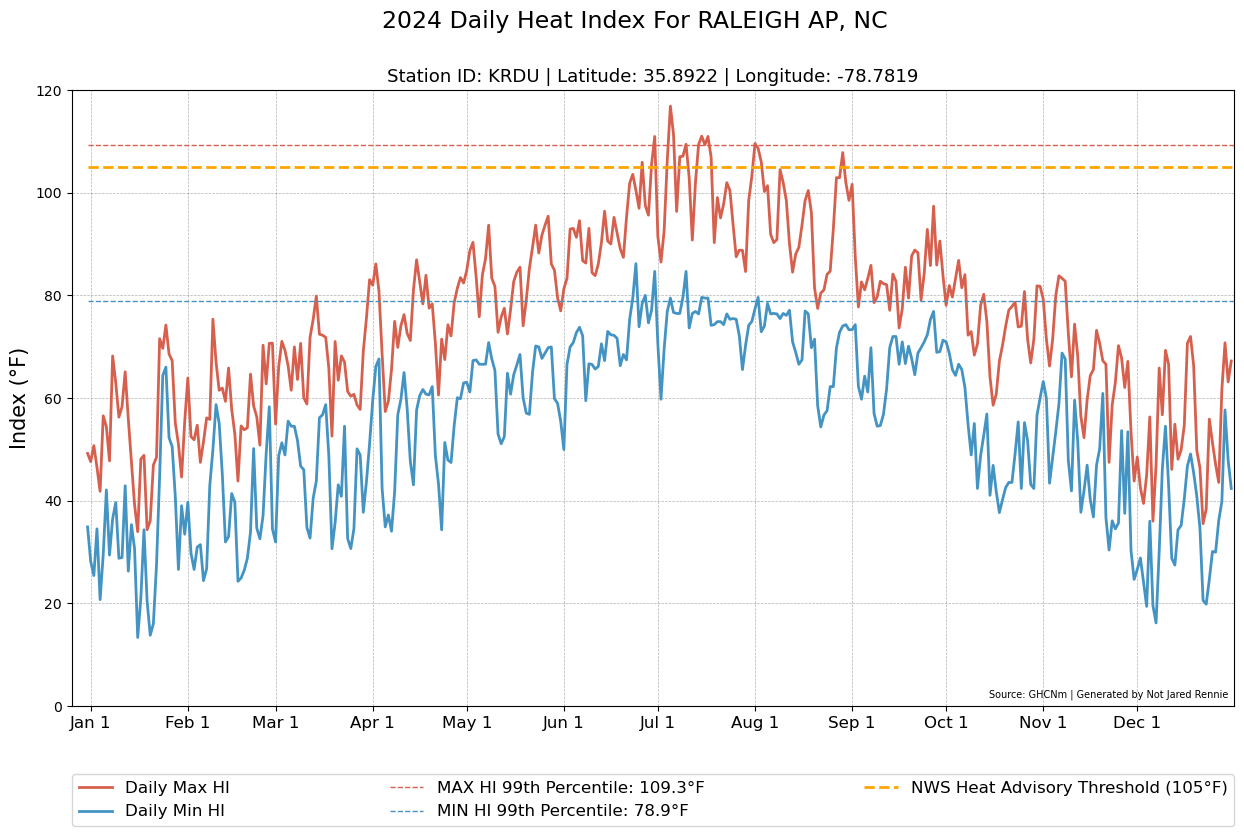

CPU times: user 1.22 s, sys: 290 ms, total: 1.51 s
Wall time: 1.08 s


In [24]:
%%time 
inYear=2024

#################################################
# PLOT
print("PLOTTING")

dpi=100
for index, row in stationMeta.iterrows():
    stationID=row['ICAO']
    stnName=row['NAME']
    stnState=row['STATE']
    stnLat=row['LATITUDE']
    stnLon=row['LONGITUDE']
    
    print(stationID)
    plotData=inDataDaily[stationID][inDataDaily[stationID]['DATE'].dt.year==inYear]
    
    # Set up the plot
    fig, axf = plt.subplots(figsize=(15, 8), edgecolor='white', facecolor='white', dpi=dpi)
    
    # Add grid lines
    plt.grid(color='black', linestyle='--', linewidth=0.5, alpha=0.3)

    # Plot Raw MAX/MIN
    plt.plot(np.arange(0,len(plotData['HI_max'])), plotData['HI_max'], linewidth=2, color='#D6604D', label="Daily Max HI",zorder=99)
    plt.plot(np.arange(0,len(plotData['HI_min'])), plotData['HI_min'], linewidth=2, color='#4393C3', label="Daily Min HI",zorder=99)

    # Plot 99th Percentile
    plt.hlines(float(perc_99_max[stationID]),0,len(plotData['HI_max']),colors='#D6604D',linewidth=1, linestyles='dashed',label="MAX HI 99th Percentile: "+str(perc_99_max[stationID])+"°F",zorder=100)
    plt.hlines(float(perc_99_min[stationID]),0,len(plotData['HI_min']),colors='#4393C3',linewidth=1, linestyles='dashed',label="MIN HI 99th Percentile: "+str(perc_99_min[stationID])+"°F",zorder=100)

    # Plot NWS Heat Advisory Threshold
    plt.hlines(float(105.),0,len(plotData['HI_max']),colors='orange',linewidth=2, linestyles='dashed',label="NWS Heat Advisory Threshold (105°F)",zorder=100)
    
    # Plot Legend
    plt.legend(bbox_to_anchor=(0., -.195, 1., -1.02), loc=3, ncol=3, mode="expand", borderaxespad=0., fontsize=12)
    
    # Set X/Y limits
    ymin=0
    ymax=120
    plt.ylim(ymin, ymax)
    plt.xlim(-5, 366) 
    
    # Plot X-Axis Labels/Ticks
    month_pos=[1,32,60,91,121,152,182,213,244,274,305,335]
    month_names=["Jan 1","Feb 1","Mar 1","Apr 1","May 1","Jun 1","Jul 1","Aug 1","Sep 1","Oct 1","Nov 1","Dec 1"]
    plt.xticks(month_pos, month_names, fontsize=12, color='black')
    
    # Plot Y-Axis Labels/Ticks (Left Side, degF)
    plt.ylabel(r'Index (°F)', fontsize=15, color='black')
    
    # Plot Title/Subtitle/Annotations
    plt.suptitle(str(inYear)+' Daily Heat Index For '+stnName+', '+stnState, fontsize=17,color='black')
    plt.title('Station ID: '+stationID+' | Latitude: '+str(stnLat)+' | Longitude: '+str(stnLon), fontsize=13,color='black')
    plt.annotate('Source: GHCNm | Generated by '+author,xy=(0.995, 0.01), xycoords='axes fraction', fontsize=7,horizontalalignment='right', verticalalignment='bottom')
    
    # Save Figure
    outfile = './'+stationID+'_hi_'+str(inYear)+'.png'
    plt.savefig(outfile, dpi=dpi,bbox_inches='tight')
    plt.show()

***ONCE AGAIN*** While RDU's temperatures can exceed its 99th percentile and 105°F NWS threshold, it is much harder to do that for Asheville.

But maybe I haven't convinced you yet. Some of you are probably still wondering *"HEY you're only using 1 percentile threshold for each variable, what about a daily percentile based on a climatology?"*

Ok fine, we can do that too, we do love our climatologies after all.

### Build a 30-year daily percentile threshold 
The following block of code will do this, since you asked so nicely. We define our normal period as 1991-2020, but feel free to change it if you'd like

In [25]:
%%time

normals_start=1991
normals_end=2020

percentiles = [0.50, 0.90, 0.95, 0.99]
daily_percentiles={}

# Create daily percentiles
for stationID in stationIDS: 
    df = inDataDaily[stationID].copy()
    
    # Filter to normals
    df = df[(df['DATE'].dt.year >= normals_start) & (df['DATE'].dt.year <= normals_end)]
    
    # Extract month and day (day-of-year with leap day preserved)
    df['MMDD'] = df['DATE'].dt.strftime('%m-%d')  # e.g., '01-01', '02-29', etc.

    # Group by percentiles
    grouped = df.groupby('MMDD')[['HI_max', 'HI_min']].quantile(percentiles).reset_index()

    # Pivot so each (HI_max, percentile) becomes a column
    pivoted = grouped.pivot(index='MMDD', columns='level_1')

    # Flatten MultiIndex column names
    pivoted.columns = [f"{var}_{int(p*100)}" for var, p in pivoted.columns]

    # Reset index so MMDD is a column again
    pivoted = pivoted.reset_index()

    # Store in dictionary
    daily_percentiles[stationID] = pivoted

CPU times: user 100 ms, sys: 21 µs, total: 100 ms
Wall time: 99.7 ms


Let's see the results:

In [26]:
print(stationID1)  #AVL
daily_percentiles[stationID1]

KAVL


,MMDD,HI_max_50,HI_max_90,HI_max_95,HI_max_99,HI_min_50,HI_min_90,HI_min_95,HI_min_99
0,01-01,47.1360,62.0533,63.49610,64.54322,25.7335,43.4730,46.63040,51.47662
1,01-02,47.8385,60.5137,61.90065,64.31016,29.5360,41.8629,44.25795,46.47622
2,01-03,46.0705,61.8371,64.97090,68.83160,28.2810,43.8546,45.36015,50.44383
3,01-04,45.7245,64.1509,68.69530,69.22070,24.8545,45.1892,46.10695,52.43202
4,01-05,46.7680,62.6787,63.33815,64.65507,25.0655,43.5558,47.66335,51.57522
...,...,...,...,...,...,...,...,...,...
361,12-27,45.3045,60.8803,61.21740,67.46920,24.8125,39.4136,45.65505,56.10000
362,12-28,47.2080,60.0361,62.10915,65.45694,26.2490,45.5524,46.88300,52.96316
363,12-29,50.4815,60.1323,67.16300,69.82448,31.9490,47.3706,51.87290,57.16192
364,12-30,47.4585,62.1807,63.62820,65.92180,28.5880,39.9907,43.42930,48.00691


In [27]:
print(stationID2)  #RDU
daily_percentiles[stationID2]

KRDU


,MMDD,HI_max_50,HI_max_90,HI_max_95,HI_max_99,HI_min_50,HI_min_90,HI_min_95,HI_min_99
0,01-01,49.6510,65.6868,68.66360,70.38638,32.7575,46.6414,53.42030,56.87179
1,01-02,51.3695,62.7040,66.28665,69.80936,33.5865,43.3594,45.85315,46.83848
2,01-03,50.4750,69.3724,70.90150,72.32396,31.7610,47.0638,49.48705,53.57172
3,01-04,47.4105,69.1927,73.18055,74.78866,33.5935,52.6407,55.72910,56.88238
4,01-05,50.3000,70.4916,71.93565,74.56343,25.7235,57.7856,60.79290,62.19600
...,...,...,...,...,...,...,...,...,...
361,12-27,48.3115,64.3411,66.43805,73.22092,27.1650,41.0499,46.92510,61.12455
362,12-28,51.5220,67.9757,69.81285,72.63950,28.6300,47.1377,49.35195,53.70718
363,12-29,54.3270,71.2124,72.44320,74.35086,32.7625,51.4319,54.15765,55.34133
364,12-30,52.0770,66.8466,72.44615,74.35392,32.4885,48.5288,55.64140,63.05288


Ok this is data overload. Let's take a year's worth of data, and see how many times it exceeds it's threshold. Again, for the sake of sanity, let's only do summer months. Below is the function to calculate these daily percentile exceedances.

In [28]:
def count_exceedances(dailyData, percentiles_df, percentile):
    # Step 1: Create MM-DD key for joining
    dailyData = dailyData.copy()
    dailyData['MMDD'] = dailyData['DATE'].dt.strftime('%m-%d')

    # Step 2: Merge dailyData with percentile thresholds
    merged = pd.merge(dailyData, percentiles_df[['MMDD', 
                                                  f'HI_max_{percentile}', 
                                                  f'HI_min_{percentile}']],
                      on='MMDD', how='left')

    # Step 3: Compare and count exceedances
    hi_max_exceed = (merged['HI_max'] > merged[f'HI_max_{percentile}']).sum()
    hi_min_exceed = (merged['HI_min'] > merged[f'HI_min_{percentile}']).sum()

    return hi_max_exceed, hi_min_exceed

Now Let's pick a year and see the results

In [29]:
inYear=2024
percentiles = [90, 95, 99]

# Provide stats to prove point
for stationID in stationIDS: 
    print('\n',stationID)

    # Get daily data for particular summer (June July August)
    dailyData=inDataDaily[stationID][inDataDaily[stationID]['DATE'].dt.year==inYear].reset_index()
    dailyData=dailyData[dailyData['DATE'].dt.month.between(6, 8)].copy()

    # Provide Exceedances For NWS 105°F Criteria 
    exceed_100_max = (dailyData['HI_max'] > 105).sum()
    print(f"HI_max {inYear} exceeded 105°F on {exceed_100_max} days")

    # Provide Exceedances For Each Percentile
    for perc in percentiles:
        hiMaxResults, hiMinResults = count_exceedances(dailyData=dailyData,
                                                       percentiles_df=daily_percentiles[stationID],
                                                       percentile=perc)
        
        print(f"HI_max {inYear} exceeded {perc}th percentile on {hiMaxResults} days")


 KAVL
HI_max 2024 exceeded 105°F on 0 days
HI_max 2024 exceeded 90th percentile on 22 days
HI_max 2024 exceeded 95th percentile on 14 days
HI_max 2024 exceeded 99th percentile on 7 days

 KRDU
HI_max 2024 exceeded 105°F on 18 days
HI_max 2024 exceeded 90th percentile on 28 days
HI_max 2024 exceeded 95th percentile on 20 days
HI_max 2024 exceeded 99th percentile on 14 days


Pick a year, any year, but the results are the same. <span style="color: red">***Using an arbitrary threhold of 105°F does not accuractely depict extreme heat!!!***</span> More relative, **percentile thresholds** reflect local conditions, and can be tailored in a way to show extreme heat is a problem anywhere.

Thanks for coming to my Ted Talk, and if you work for the National Weather Service please contact me ASAP.

**Congrats on completing this notebook! Now go forth and make better data/plots!**